# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we explore some of the textual features of those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 

In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import nltk
import regex as re
import glob
import matplotlib.pyplot as plt

nltk.download('stopwords')

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/Chris/Downloads/M1 Results/"

# These subfolders should still work if you correctly stored the data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [3]:
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    """

    # Fill in the correct values here.
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0.0
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        token_counts = Counter(tokens)
        most_common_tokens = token_counts.most_common(num_tokens)
        print(f"\nMost common tokens:")
        for token, count in most_common_tokens[:5]:
            print(f"{token}: {count} times")

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

In [4]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)

There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.

Most common tokens:
text: 3 times
here: 2 times
example: 2 times
is: 1 times
some: 1 times


Q: Why is it beneficial to use assertion statements in your code? 

A: Assertion statements play a crucial role for debugging and testing. They assist in detecting issues and facilitate the debugging process whenever errors occur. This allows developers to pinpoint problems during the development phase, enhancing the code's reliability and overall quality.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.

In [5]:
# Read in the lyrics data

# Create a dictionary to store the lyrics data
lyrics_data = {}

# Define the path to the folder containing lyrics data
lyrics_folder_path = data_location + lyrics_folder

# Iterate through the subfolders for different artists
for artist_folder in os.listdir(lyrics_folder_path):
    artist_path = os.path.join(lyrics_folder_path, artist_folder)
    if os.path.isdir(artist_path):
        artist_name = artist_folder  # Use the artist folder name as the artist's name
        lyrics_data[artist_name] = {}  # Create a sub-dictionary for the artist
        
        # Iterate through text files in the artist's folder (assuming each file is a song)
        for song_file in os.listdir(artist_path):
            if song_file.endswith(".txt"):
                song_name = song_file.split(".")[0]  # Extract song name from the filename
                with open(os.path.join(artist_path, song_file), "r", encoding = "utf-8") as file:
                    lyrics_text = file.read()  # Read the entire contents of the file
                    # Store the lyrics data in the sub-dictionary
                    lyrics_data[artist_name][song_name] = lyrics_text

In [6]:
# Read in the Twitter data

# Define the path to the folder containing Twitter data
twitter_folder_path = data_location + twitter_folder
os.chdir(twitter_folder_path)
twitter_files = os.listdir(twitter_folder_path)

desc_files = [f for f in twitter_files if "followers_data" in f]
twitter_data = defaultdict(list)
for f in desc_files :
    artist = f.split("_")[0]

    with open(twitter_folder_path + f, 'r', encoding = 'utf8') as infile :
        next(infile)
        for idx, line in enumerate(infile.readlines()) :
            line = line.strip().split("\t")
            if len(line) == 7 :
                twitter_data[artist].append(line[6])

## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame.

In [7]:
punctuation = set(punctuation) # speeds up comparison

In [8]:
# Create your clean Twitter data here

# Define a function to remove stopwords
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

# Define a function to tokenize text
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

# Define a function to prepare text using a pipeline of transformations
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

# Create a dataFrame from the Twitter data
twitter_df = pd.DataFrame([(k, x) for k, v in twitter_data.items() for x in v], columns = ['artist', 'tweet'])

# Apply the prepare function to tokenize and remove stopwords
twitter_df['tokens'] = twitter_df['tweet'].apply(prepare, pipeline = pipeline)

# Separate tweets by artists
cher_tweets = twitter_df[twitter_df["artist"] == "cher"]
robyn_tweets = twitter_df[twitter_df["artist"] != "cher"]

In [9]:
# Create your clean lyrics data here

# Create a dictionary to store cleaned lyrics data
cleaned_lyrics_data = {}

# Iterate through the original lyrics_data dictionary
for artist, songs in lyrics_data.items():
    # Create a sub-dictionary for the artist
    cleaned_lyrics_data[artist] = {}
    
    for song, lyrics in songs.items():
        # Clean the lyrics text
        cleaned_lyrics = lyrics.lower()  # Convert to lowercase
        cleaned_lyrics = cleaned_lyrics.replace("\n", " ")  # Remove line breaks
        cleaned_lyrics = cleaned_lyrics.strip()  # Remove leading/trailing white spaces
         
        # Store the cleaned lyrics
        cleaned_lyrics_data[artist][song] = cleaned_lyrics

## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [10]:
# Calls to descriptive_stats here

# Call descriptive_stats for lyrics data
for artist, songs in cleaned_lyrics_data.items():
    for song, lyrics in songs.items():
        print(f"Descriptive stats for lyrics of artist: {artist}, song: {song}")

        # Split lyrics into tokens
        stats = descriptive_stats(lyrics.split())
        print("\n")

Descriptive stats for lyrics of artist: cher, song: cher_88degrees
There are 326 tokens in the data.
There are 117 unique tokens in the data.
There are 1226 characters in the data.
The lexical diversity is 0.359 in the data.

Most common tokens:
the: 19 times
so: 16 times
to: 11 times
is: 9 times
cause: 9 times


Descriptive stats for lyrics of artist: cher, song: cher_adifferentkindoflovesong
There are 262 tokens in the data.
There are 82 unique tokens in the data.
There are 1018 characters in the data.
The lexical diversity is 0.313 in the data.

Most common tokens:
of: 19 times
different: 16 times
kind: 16 times
love: 16 times
a: 14 times


Descriptive stats for lyrics of artist: cher, song: cher_afterall
There are 292 tokens in the data.
There are 97 unique tokens in the data.
There are 1149 characters in the data.
The lexical diversity is 0.332 in the data.

Most common tokens:
to: 15 times
all: 15 times
and: 13 times
after: 12 times
it: 11 times


Descriptive stats for lyrics of 

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: The top five words would consist of stopwords words that do not provide significance such as `a`, `an`, `the`, `and`, and `it`.

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: Initially, I believed that Cher exhibited a greater degree of lexical diversity in her lyrics compared to Robyn. Cher's songs tend to be more simple, often featuring noticeable repetitions of words and phrases. In contrast, Robyn's songwriting style seemed to encompass a broader range of word types and expressions. This was illustrated by the descriptive statistics function.


## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.

In [11]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [12]:
# Function to check if a tweet contains an emoji
def contains_emoji(tweet):
    for char in tweet:
        if emoji.is_emoji(char):
            return True
    return False

# Apply the function to Cher's tweets
cher_tweets['has_emoji'] = cher_tweets['tweet'].apply(contains_emoji)

# Extract and create a dataFrame of Cher's emojis
cher_emojis = pd.DataFrame([char for tweet in cher_tweets['tweet'] for char in tweet if emoji.is_emoji(char)], columns = ['emojis'])

# Apply the function to Robyn's tweets
robyn_tweets['has_emoji'] = robyn_tweets['tweet'].apply(contains_emoji)

# Extract and create a dataFrame of Robyn's emojis
robyn_emojis = pd.DataFrame([char for tweet in robyn_tweets['tweet'] for char in tweet if emoji.is_emoji(char)], columns = ['emojis'])

C:\Users\Chris\AppData\Local\Temp\ipykernel_4632\797974500.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cher_tweets['has_emoji'] = cher_tweets['tweet'].apply(contains_emoji)
C:\Users\Chris\AppData\Local\Temp\ipykernel_4632\797974500.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  robyn_tweets['has_emoji'] = robyn_tweets['tweet'].apply(contains_emoji)


In [13]:
print("Top 10 Emojis for Cher:")
print(cher_emojis['emojis'].value_counts()[:10].index.tolist())

print("\n Top 10 Emojis for Robyn:")
print(robyn_emojis['emojis'].value_counts()[:10].index.tolist())

Top 10 Emojis for Cher:
['❤', '🌈', '♥', '🏳', '✨', '💙', '🏻', '🌊', '✌', '💜']

 Top 10 Emojis for Robyn:
['❤', '🌈', '🏳', '♥', '✨', '🏻', '✌', '🏼', '♀', '💙']


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [14]:
# Function to extract hashtags from tweets
def extract_hashtags(tweet):
    return [tag for tag in tweet.split() if tag.startswith("#")]

# Extract hashtags from Cher's tweets
cher_hashtags = cher_tweets['tweet'].apply(extract_hashtags).explode().value_counts()

# Extract hashtags from Robyn's tweets
robyn_hashtags = robyn_tweets['tweet'].apply(extract_hashtags).explode().value_counts()

In [15]:
print("Top 10 Hashtags for Cher:")
print(cher_hashtags.head(10).index.tolist())

print("\nTop 10 Hashtags for Robyn:")
print(robyn_hashtags.head(10).index.tolist())

Top 10 Hashtags for Cher:
['#BLM', '#Resist', '#BlackLivesMatter', '#resist', '#FBR', '#blacklivesmatter', '#TheResistance', '#1', '#', '#Resistance']

Top 10 Hashtags for Robyn:
['#BlackLivesMatter', '#BLM', '#blacklivesmatter', '#1', '#', '#music', '#Music', '#EDM', '#TeamFollowBack', '#blm']


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.

In [16]:
# Function to get the most common words in song titles for a specific artist
def most_common_words_for_artist(artist_name, lyrics_data):
    # Extract song titles for the specified artist
    song_titles = []

    if artist_name in lyrics_data:
        songs = lyrics_data[artist_name]
        for song, lyrics in songs.items():
            # Split lyrics into lines and take the first line as the song title
            lines = lyrics.split('\n')
            if lines:
                # Extract and clean the song title
                song_title = lines[0].strip()
                song_titles.append(song_title)

    # Combine all song titles into a single text
    all_song_titles = " ".join(song_titles)

    # Tokenize the combined song titles
    title_tokens = all_song_titles.split()

    # Calculate the 5 most common words in song titles for artist
    common_words = Counter(title_tokens).most_common(5)
    return common_words

# Iterate through artists and find the most common words in song titles for each artist
for artist_name in cleaned_lyrics_data.keys():
    common_words = most_common_words_for_artist(artist_name, cleaned_lyrics_data)
    
    # Print the results for each artist
    print(f"Top 5 Common words in Song Titles for {artist_name}:")
    for word, count in common_words:
        print(f"{word}: {count} times")
    print("\n")

Top 5 Common words in Song Titles for cher:
you: 2655 times
i: 2649 times
the: 2423 times
to: 1686 times
and: 1562 times


Top 5 Common words in Song Titles for robyn:
you: 1438 times
the: 867 times
i: 836 times
me: 667 times
to: 664 times




### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out.

artist
Artist 1    AxesSubplot(0.125,0.11;0.775x0.77)
Artist 2    AxesSubplot(0.125,0.11;0.775x0.77)
Name: length, dtype: object

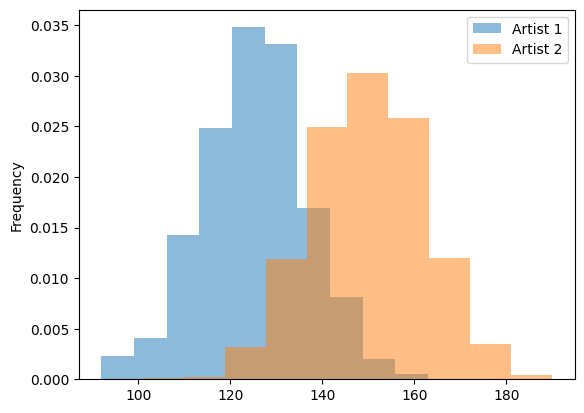

In [17]:
num_replicates = 1000

df = pd.DataFrame({
    "artist" : ['Artist 1'] * num_replicates + ['Artist 2'] * num_replicates,
    "length" : np.concatenate((np.random.poisson(125, num_replicates), np.random.poisson(150, num_replicates)))
})

df.groupby('artist')['length'].plot(kind = "hist", density = True, alpha = 0.5, legend = True)

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: The regular expression `'\s+'` matches one or more whitespace characters in a string.

In [18]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

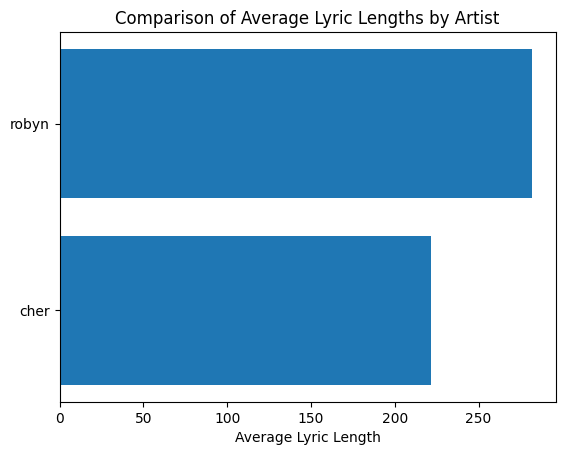

In [19]:
# Your lyric length comparison chart here

# Create a dictionary to store average lyric lengths for each artist
average_lyric_lengths = {}

# Calculate the average lyric length for each artist
for artist_name, songs in cleaned_lyrics_data.items():
    total_length = 0
    total_songs = len(songs)
    
    for song, lyrics in songs.items():
        # Calculate the length of each song's lyrics
        song_length = len(lyrics.split())
        total_length += song_length
    
    # Calculate the average length for the artist
    average_length = total_length / total_songs
    average_lyric_lengths[artist_name] = average_length

# Create a bar chart to visualize the average lyric lengths
plt.barh(list(average_lyric_lengths.keys()), list(average_lyric_lengths.values()))
plt.xlabel('Average Lyric Length')
plt.title('Comparison of Average Lyric Lengths by Artist')
plt.show()

In [20]:
# Print the average lyric lengths for each artist
print("Average Lyric Lengths by Artist:")
for artist_name, average_length in average_lyric_lengths.items():
    print(f"{artist_name}: {average_length:.2f} words per song on average")

Average Lyric Lengths by Artist:
cher: 221.83 words per song on average
robyn: 281.90 words per song on average
